# 📊 LinkedIn Data Science Jobs Tracker - Exploratory Data Analysis
*por Renan*  

**Objetivo**: Usar o arquivo .csv com as vagas carregadas para avaliar o perfil.  
**Tecnologias**: Python, BeautifulSoup, Requests, Pandas. 

In [1]:
#Bibliotecas utilizadas
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from time import sleep
from IPython.display import clear_output
import re
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

## 🔍 Etapa 1: Coletar IDs de Vagas  
O LinkedIn limita a 25 vagas por requisição. Esta função:  
- Usa paginação (`start=0`, `start=25`, etc.)  
- Evita bloqueios com `sleep(1)`  

In [2]:
def coletar_job_ids(keyword, location, limit=50):
    base_url = "https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search"
    job_ids = []
    start = 0

    while len(job_ids) < limit:
        parametros_busca = {"keywords":keyword, "location":location, "start": start}
        try:
            response = requests.get(base_url, params=parametros_busca, timeout=10)
            print(f"URL da requisição: {response.url}")

            soup = BeautifulSoup(response.text, "html.parser")
            jobs_list = soup.find_all("li")
            if not jobs_list:
                print("Fim da busca de vagas!")
                break

            for job_found in jobs_list:
                job_id = job_found.find("div", {"class": "base-card"}).get("data-entity-urn", "").split(":")[-1]
                
                if job_id:
                    job_ids.append(job_id)
            start += 25  # Avança para a próxima página
            sleep(1)  # Evita bloqueio

        except Exception as e:
            print(f"Erro na requisição: {e}")
            break

    return job_ids[:limit]

In [3]:
def coletar_job_detalhes(job_id):
    url = f"https://www.linkedin.com/jobs-guest/jobs/api/jobPosting/{job_id}"

    try:
        response = requests.get(url, timeout=10)
        soup = BeautifulSoup(response.text, "html.parser")


        job_details = {
            "title": soup.find("h2", class_="top-card-layout__title").get_text(strip=True) 
                    if soup.find("h2", class_="top-card-layout__title") else "N/A",
            "company": soup.find("a", class_="topcard__org-name-link").get_text(strip=True) 
                    if soup.find("a", class_="topcard__org-name-link") else "N/A",
            "location": soup.find("span", class_="topcard__flavor--bullet").get_text(strip=True) 
                    if soup.find("span", class_="topcard__flavor--bullet") else "N/A",
            "posted": soup.find("span", class_="posted-time-ago__text").get_text(strip=True) 
                    if soup.find("span", class_="posted-time-ago__text") else "N/A",
            "description": soup.find("div", class_="description__text").get_text(strip=True)
                    if soup.find("div", class_="description__text") else "N/A",
            "applicants": soup.find("span", class_="num-applicants__figure").get_text(strip=True) 
                    if soup.find("span", class_="num-applicants__figure") else "N/A",
            "work_mode": "Remote" if "remote" in soup.get_text().lower() else "On-site/Hybrid",
            "link": url
        }
        return job_details

    except Exception as e:
        print(f"Erro ao processar vaga {job_id}: {e}")
        return None

In [4]:
job_ids = coletar_job_ids("Cientista de Dados", "São Paulo")

URL da requisição: https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords=Cientista+de+Dados&location=S%C3%A3o+Paulo&start=0
URL da requisição: https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords=Cientista+de+Dados&location=S%C3%A3o+Paulo&start=25
URL da requisição: https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords=Cientista+de+Dados&location=S%C3%A3o+Paulo&start=50
URL da requisição: https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords=Cientista+de+Dados&location=S%C3%A3o+Paulo&start=75
URL da requisição: https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords=Cientista+de+Dados&location=S%C3%A3o+Paulo&start=100
Fim da busca de vagas!


In [5]:
jobs = []
for i, job_id in enumerate(job_ids):
    job = coletar_job_detalhes(job_id)
    if job:
        jobs.append(job)
    sleep(1)  # Delay entre requisições
    clear_output(wait=True)
    print(f"Progresso: {i+1}/{len(job_ids)} vagas processadas")

Progresso: 40/40 vagas processadas


In [6]:
# Cria DataFrame
df = pd.DataFrame(jobs)

In [7]:
display(df.head()) 

,title,company,location,posted,description,applicants,work_mode,link
0,CIENTISTA DE DADOS III,Alper Seguros,"São Paulo, São Paulo, Brazil",2 months ago,Sobre a Alper SegurosPara proteger tudo que ma...,N/A,On-site/Hybrid,https://www.linkedin.com/jobs-guest/jobs/api/j...
1,Cientista de Dados Senior,CSU Digital,"Barueri, São Paulo, Brazil",1 month ago,O profissional irá trabalhar com um time multi...,N/A,On-site/Hybrid,https://www.linkedin.com/jobs-guest/jobs/api/j...
2,Banco de Talentos - Profissionais com Deficiência,Cognizant,Greater São Paulo Area,2 weeks ago,A Cognizant está sempre à procura de grandes t...,N/A,On-site/Hybrid,https://www.linkedin.com/jobs-guest/jobs/api/j...
3,Vaga afirmativa para Pessoas com Deficiência e...,Microsoft Innovation Center,"São Paulo, São Paulo, Brazil",1 month ago,OverviewThe goal of the Disability Hiring Even...,N/A,On-site/Hybrid,https://www.linkedin.com/jobs-guest/jobs/api/j...
4,Vaga afirmativa para Pessoas com Deficiência e...,Microsoft Power Platform Community,"São Paulo, São Paulo, Brazil",1 month ago,OverviewThe goal of the Disability Hiring Even...,N/A,On-site/Hybrid,https://www.linkedin.com/jobs-guest/jobs/api/j...


In [8]:
habilidades = ["sql", "python", "machine learning", "aws", "cloud"]

In [9]:
df["skills"] = df["description"].apply(lambda desc: [skill for skill in habilidades if re.search(rf"\b{skill}\b", desc.lower())])

In [10]:
skills_count = pd.Series([skill for sublist in df["skills"] for skill in sublist]).value_counts()
print(skills_count)

python              30
sql                 28
machine learning    21
cloud               11
aws                  7
Name: count, dtype: int64


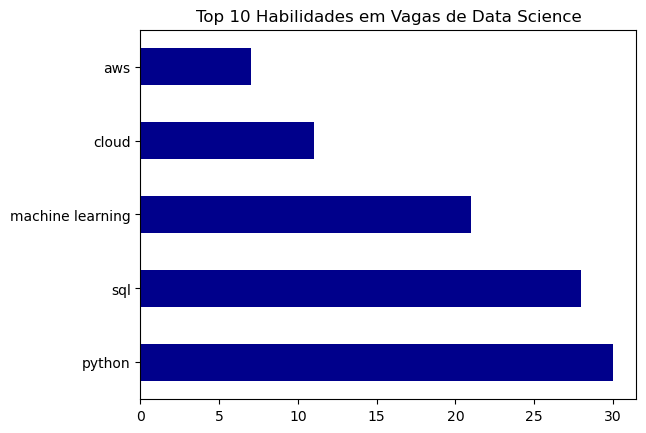

In [11]:
skills_count.plot(kind="barh", color="darkblue")
plt.title("Top 10 Habilidades em Vagas de Data Science")
plt.show()

In [12]:
df.head()

,title,company,location,posted,description,applicants,work_mode,link,skills
0,CIENTISTA DE DADOS III,Alper Seguros,"São Paulo, São Paulo, Brazil",2 months ago,Sobre a Alper SegurosPara proteger tudo que ma...,N/A,On-site/Hybrid,https://www.linkedin.com/jobs-guest/jobs/api/j...,"[python, machine learning, cloud]"
1,Cientista de Dados Senior,CSU Digital,"Barueri, São Paulo, Brazil",1 month ago,O profissional irá trabalhar com um time multi...,N/A,On-site/Hybrid,https://www.linkedin.com/jobs-guest/jobs/api/j...,"[sql, python, machine learning]"
2,Banco de Talentos - Profissionais com Deficiência,Cognizant,Greater São Paulo Area,2 weeks ago,A Cognizant está sempre à procura de grandes t...,N/A,On-site/Hybrid,https://www.linkedin.com/jobs-guest/jobs/api/j...,[]
3,Vaga afirmativa para Pessoas com Deficiência e...,Microsoft Innovation Center,"São Paulo, São Paulo, Brazil",1 month ago,OverviewThe goal of the Disability Hiring Even...,N/A,On-site/Hybrid,https://www.linkedin.com/jobs-guest/jobs/api/j...,"[sql, python, cloud]"
4,Vaga afirmativa para Pessoas com Deficiência e...,Microsoft Power Platform Community,"São Paulo, São Paulo, Brazil",1 month ago,OverviewThe goal of the Disability Hiring Even...,N/A,On-site/Hybrid,https://www.linkedin.com/jobs-guest/jobs/api/j...,"[sql, python, cloud]"


In [13]:
descricao_habilidades = df["description"]

In [14]:
palavras = " ".join(palavra for palavra in descricao_habilidades)

In [15]:
stopwords = set(STOPWORDS)

In [16]:
stopwords.update(['vaga', 'nós', 'estar', 'será', 'todos', 'das', 'sempre', 'will', 'etc', 'fazer', 'aos', 'ano', 'os', 'até', 'suas', 'ser', 'além', 'pessoa', 'cada', 'à', 'todas', 'são', 'não', 'nos', 'sua', 'nossos', 'sobre', 'utilizando', 'nossa', 'onde', 'dia', 'todo', 'a', 'de', 'e', 'para', 'em', 'da', 'atividades', 'principais', 'do', 'somos', 'um', 'é', 'está', 'busca', 'buscando', 'dados', 'que', 'o', 'nosso', 'na', 'como', 'você', 'trabalhar', 'ou', 'mais','ao','seu','por','toda','less', 'more', 'Show', 'se', 'uma', 'dos', 'estamos', 'moreShow', 'você', 'deficiência', 'disability', 'odontológico', 'saúde', 'nossas', 'Entrevista', 'anos','parte','pelo', 'Desconto', 'aqui'])

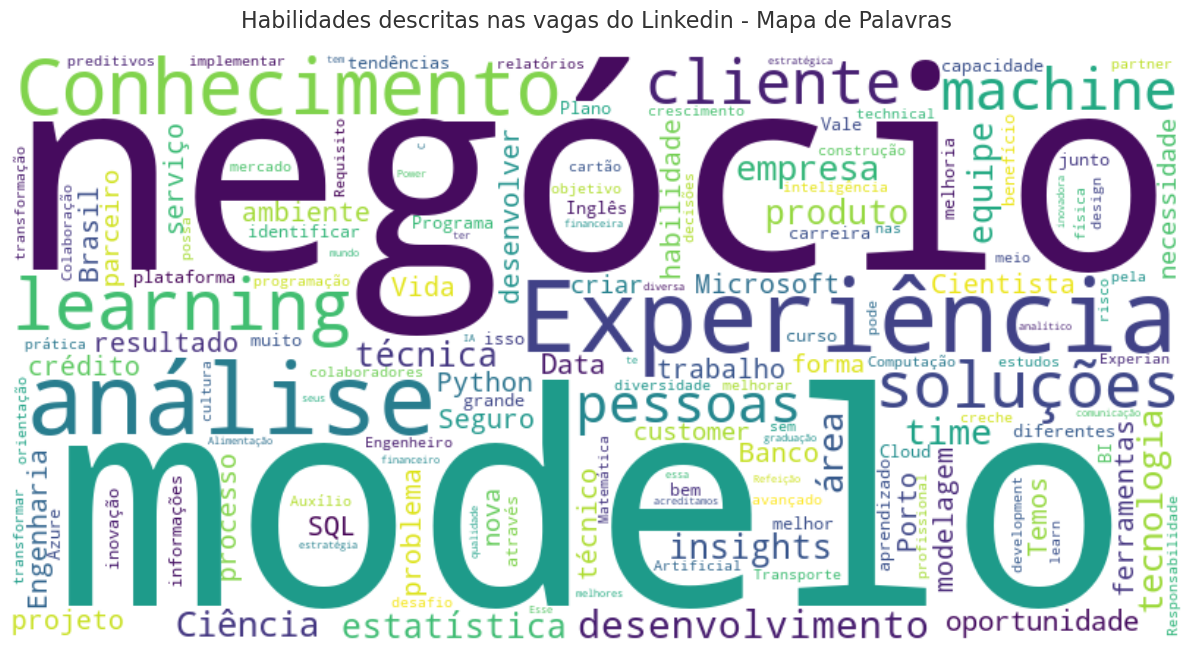

In [17]:
wordcloud = WordCloud(stopwords=stopwords,
    width=800, 
    height=400,
    background_color='white',  # fundo branco
    colormap='viridis',       # esquema de cores
    contour_width=1,          # borda ao redor da nuvem
    contour_color='steelblue',# cor da borda
    max_words=150,            # limitar número de palavras
    collocations=False,       # evitar repetições de frases
    prefer_horizontal=0.8,    # proporção de palavras horizontais
    min_font_size=4,          # tamanho mínimo da fonte
    random_state=42           # para reprodutibilidade
).generate(palavras)

# Configurar figura
plt.figure(figsize=(12, 8), facecolor='white', edgecolor='blue')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Título
plt.title("Habilidades descritas nas vagas do Linkedin - Mapa de Palavras", 
          fontsize=16, pad=20, color='#333333')
plt.tight_layout(pad=1)  # ajustar espaçamento

# Opcional: salvar
#plt.savefig('wordcloud_profissional.png', dpi=300, bbox_inches='tight', quality=100)

plt.show()

In [ ]:

df["skills"] = df["description"].apply(lambda desc: [skill for skill in habilidades if re.search(rf"\b{skill}\b", desc.lower())])

# Contagem de habilidades
skills_count = pd.Series([skill for sublist in df["skills"] for skill in sublist]).value_counts()
print(skills_count)

In [ ]:
df.to_csv("linkedin_datasciecen_jobs.csv", index=False, encoding="utf-8-sig")
print("Dados salvos em 'linkedin_datasciecen_jobs.csv'")